In [43]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.optimize as optim
from scipy import stats
import cvxpy as cp
from tqdm import tqdm
import json
import os
import sys
import seaborn as sns
import pandas as pd
from pandapower import networks as pn
from pandapower import estimation as est
import pandapower as pp
from pandapower import OPFNotConverged
from scipy.stats import multivariate_normal
from copy import deepcopy
import pickle
sys.path.append('..')


from src.data_utils import grid_data
from src.estimators.adaptive import AdaptiveEstimator
from src.estimators.static import SecurityAssessmentEstimator
from src.samplers.sampler import Sampler

# Read case 

In [44]:
path_to_saves = '../saves'
if not os.path.exists(path_to_saves):
    os.makedirs(path_to_saves)

# Solve OPF before the action if needed, record resulting p_mw on generators and voltage magnitudes on them

In [45]:
net = pn.case9()
# pp.runopp(net, numba=True)
# net.res_gen
# net.gen['p_mw'] = net.res_gen['p_mw']
# net.gen['vm_pu'] = net.res_gen['vm_pu']
# net.gen

# Define fluctuating buses and generators and setup estimators

In [46]:
fluct_gen = [0, 1]
fluct_load = [0, 1, 2]
adaestimator = AdaptiveEstimator(net=net, fluct_gens_idxs=fluct_gen, fluct_loads_idxs=fluct_load, mu_init=np.ones(len(fluct_gen)) * 0, sigma_init=(np.ones(len(fluct_gen))*500, np.ones(len(fluct_load))*500), batch_size=10)
staticestimator = SecurityAssessmentEstimator(net, fluct_gen, fluct_load)

# Define sample functions for MC estimation and make estimation with static MC estimator

In [47]:
get_sample = lambda: np.random.multivariate_normal(np.zeros(len(fluct_gen)), np.eye(len(fluct_gen)) * 500)
get_sample_load = lambda: {"P": np.random.multivariate_normal(np.zeros(len(fluct_load)), np.eye(len(fluct_load)) * 500), 
                            "Q": np.random.multivariate_normal(np.zeros(len(fluct_load)), np.eye(len(fluct_load)) * 500), }
sampler = Sampler(len(fluct_gen), len(fluct_load), get_sample, get_sample_load).sample()
samples = [(next(sampler), ) for i in range(5000)]
estimate_static = staticestimator.estimate(samples, parallel=True)

# Plots

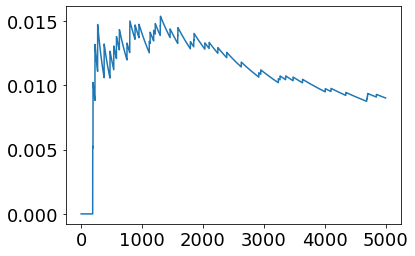

In [48]:
mc_estimates = [np.sum(estimate_static[:i]) / i for i in range(1, len(estimate_static))]
plt.plot(mc_estimates)
if not os.path.exists(path_to_saves):
    os.makedirs(path_to_saves)
plt.savefig(path_to_saves + "mc.png")

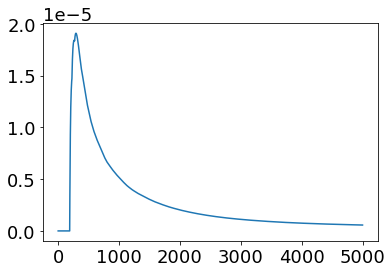

In [49]:
mc_std_estimates = [np.std(mc_estimates[:i]) / i for i in range(1, len(mc_estimates))]
plt.plot(mc_std_estimates)
if not os.path.exists(path_to_saves):
    os.makedirs(path_to_saves)
plt.savefig(path_to_saves + "mc_std.png")

In [50]:
with open(os.path.join(path_to_saves, 'mc_esimator.pkl'), 'wb') as fs:
    pickle.dump((staticestimator, mc_estimates), fs)

# Estimate with adaptive one

In [51]:
adaestimator.test_samples(5000)

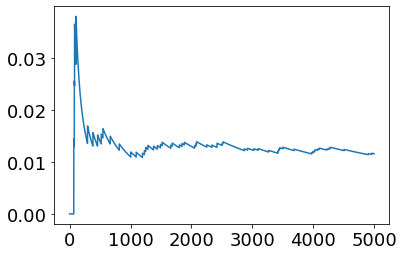

In [52]:
is_estimates = [np.sum(adaestimator.weightes_outcomes[:i]) / i for i in range(1, adaestimator.n_steps)]
plt.plot(is_estimates)
if not os.path.exists(path_to_saves):
    os.makedirs(path_to_saves)
plt.savefig(path_to_saves + "adaest.png")

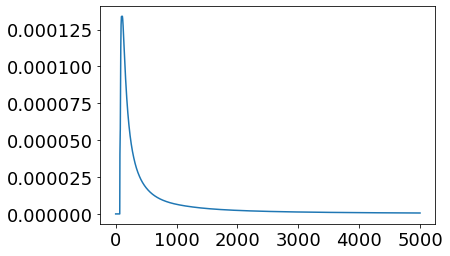

In [53]:
is_std_estimates = [np.std(is_estimates[:i]) / i for i in range(1, len(is_estimates))]
plt.plot(is_std_estimates)
if not os.path.exists(path_to_saves):
    os.makedirs(path_to_saves)
plt.savefig(path_to_saves + "adaest.png")

In [54]:
delattr(adaestimator, "Isampler")
delattr(adaestimator, "Nsampler")
with open(os.path.join(path_to_saves, 'ada_esimator.pkl'), 'wb') as fs:
    pickle.dump((adaestimator, is_estimates), fs)

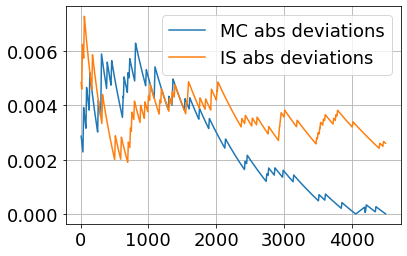

In [55]:
true_val = mc_estimates[-1]
mcs = np.abs(mc_estimates[500:] - true_val)
iss = np.abs(is_estimates[500:] - true_val)
plt.plot(pd.Series(mcs).rolling(10).mean().values, label='MC abs deviations')
plt.plot(pd.Series(iss).rolling(10).mean().values, label='IS abs deviations')
plt.legend()
plt.grid()

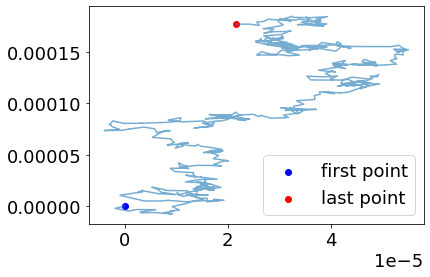

In [56]:
mus_hist = np.array(adaestimator.mu_history)
plt.plot(mus_hist[:, 0], mus_hist[:, 1], alpha=0.6)
plt.scatter([mus_hist[:, 0][0]], [mus_hist[:, 1][0]], color='blue', label='first point')
plt.scatter([mus_hist[:, 0][-1]], [mus_hist[:, 1][-1]], color='red', label='last point')
plt.legend()
if not os.path.exists(path_to_saves):
    os.makedirs(path_to_saves)
plt.savefig(path_to_saves + "adaest_path.png")

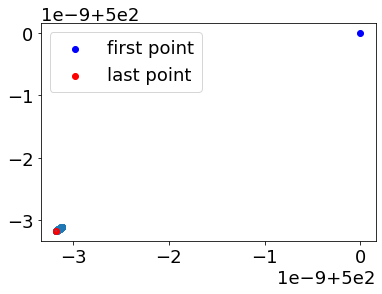

In [57]:
sigmas_hist = np.array(adaestimator.sigma_history)[1:]
plt.plot(sigmas_hist[-5:, 0], sigmas_hist[-5:, 1], alpha=0.6)
plt.scatter(sigmas_hist[-100:, 0], sigmas_hist[-100:, 1])
plt.scatter([sigmas_hist[:, 0][0]], [sigmas_hist[:, 1][0]], color='blue', label='first point')
plt.scatter([sigmas_hist[:, 0][-1]], [sigmas_hist[:, 1][-1]], color='red', label='last point')
plt.legend()
if not os.path.exists(path_to_saves):
    os.makedirs(path_to_saves)
plt.savefig(path_to_saves + "adaest_path.png")

In [58]:
grad_history = list(adaestimator.grad_history) 
grad_history[0]

array([0.00000000e+00, 0.00000000e+00, 5.62448801e-10, 5.62448801e-10])

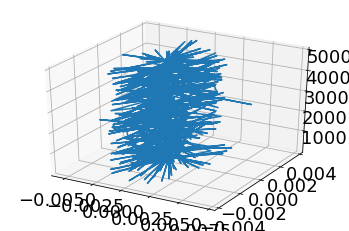

In [59]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np


fig = plt.figure()
ax = fig.gca(projection='3d')

X = np.array([item[0] for item in grad_history])
Y = np.array([item[1] for item in grad_history])
Z = np.array([i for i in range(1, adaestimator.n_steps + 1)])

# Plot the surface.
surf = ax.plot3D(X, Y, Z)

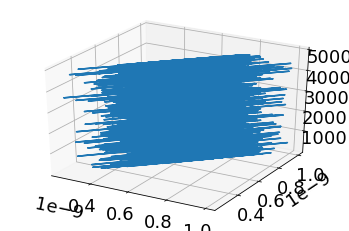

In [60]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np


fig = plt.figure()
ax = fig.gca(projection='3d')

X = np.array([item[2] for item in grad_history])
Y = np.array([item[3] for item in grad_history])
Z = np.array([i for i in range(1, adaestimator.n_steps + 1)])

# Plot the surface.
surf = ax.plot3D(X, Y, Z)

# Dump further

# We can pose that as a searching machine for the WEAKEST area of the grid 
page rank lol - https://www.sciencedirect.com/science/article/abs/pii/S0378437118309993

In [17]:
#